<b>Import Statements</b>

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
import tensorflow.keras as keras

print(dir(keras))

['Input', 'Model', 'Sequential', '__builtins__', '__cached__', '__doc__', '__file__', '__internal__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'activations', 'applications', 'backend', 'callbacks', 'constraints', 'datasets', 'dtensor', 'estimator', 'experimental', 'export', 'initializers', 'layers', 'losses', 'metrics', 'mixed_precision', 'models', 'optimizers', 'preprocessing', 'regularizers', 'saving', 'utils']


<b>Preping the data</b>

First correcting the format of the images that aren't compatable with tensorflow

In [3]:
# from utils.util import find_bad_images , format_images

data_path = '.\Data Set\Final_Data'

# bad_images = find_bad_images(data_path)
# format_images(bad_images)

<b>Loading the data</b>

In [4]:
data = tf.keras.utils.image_dataset_from_directory(data_path , labels='inferred')
class_names = data.class_names
print(class_names)

Found 11986 files belonging to 20 classes.
['Fresh Apple', 'Fresh Banana', 'Fresh Bellpepper', 'Fresh Carrot', 'Fresh Cucumber', 'Fresh Mango', 'Fresh Orange', 'Fresh Potato', 'Fresh Strawberry', 'Fresh Tomato', 'Rotten Apple', 'Rotten Banana', 'Rotten Bellpepper', 'Rotten Carrot', 'Rotten Cucumber', 'Rotten Mango', 'Rotten Orange', 'Rotten Potato', 'Rotten Strawberry', 'Rotten Tomato']


<b>Preprocessing Images</b>

Scaling the image between 0 - 1 and one hot encoding the data points

In [5]:
data = data.map(lambda  x , y : (x / 255 , tf.one_hot(y , depth=20)))


Split our data to training , validating and testing sets

In [6]:
training_amount = int(len(data) * 0.7)
validating_amount = int(len(data) * 0.2)
testing_amount = int(len(data) * 0.1)

print(f'total ratio : {(training_amount + validating_amount + testing_amount) / len(data)}')

total ratio : 0.9973333333333333


In [7]:
training_set = data.take(training_amount)
validation_set = data.skip(training_amount).take(validating_amount)
testing_set = data.skip(training_amount + validating_amount).take(testing_amount)

<b>Building the CNN model</b>

Build deep neural net

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , Dropout

In [9]:
model = Sequential()

model.add(Conv2D(64 , (3,3) , 1 , activation = 'relu' , input_shape = (256 , 256 ,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32 , (3,3) , 1 , activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64 , (3,3) , 1 , activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256 , activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(20 , activation = 'softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [11]:
model.compile(optimizer='adam' , loss="categorical_crossentropy" , metrics=['accuracy'])

Training the model

In [12]:
log_path = './logs/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path)
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta = 1e-3,
    patience=5,
    mode='auto',
    verbose=1,
    restore_best_weights=True
)

In [13]:
history = model.fit(training_set , epochs=100 , validation_data=validation_set , callbacks=[tensorboard_callback , earlystop_callback])

Epoch 1/100
262/262 [==============================] - 896s 3s/step - loss: 2.4606 - accuracy: 0.2566 - val_loss: 1.8572 - val_accuracy: 0.4604
Epoch 2/100
262/262 [==============================] - 814s 3s/step - loss: 1.7119 - accuracy: 0.4808 - val_loss: 1.4145 - val_accuracy: 0.5863
Epoch 3/100
262/262 [==============================] - 803s 3s/step - loss: 1.1994 - accuracy: 0.6282 - val_loss: 1.1529 - val_accuracy: 0.6642
Epoch 4/100
262/262 [==============================] - 802s 3s/step - loss: 0.8416 - accuracy: 0.7376 - val_loss: 1.0120 - val_accuracy: 0.7108
Epoch 5/100
262/262 [==============================] - 802s 3s/step - loss: 0.5889 - accuracy: 0.8108 - val_loss: 1.0288 - val_accuracy: 0.7333
Epoch 6/100
262/262 [==============================] - 800s 3s/step - loss: 0.4300 - accuracy: 0.8669 - val_loss: 0.9585 - val_accuracy: 0.7646
Epoch 7/100
262/262 [==============================] - 769s 3s/step - loss: 0.3186 - accuracy: 0.8993 - val_loss: 1.0731 - val_accuracy:

Plot Performance

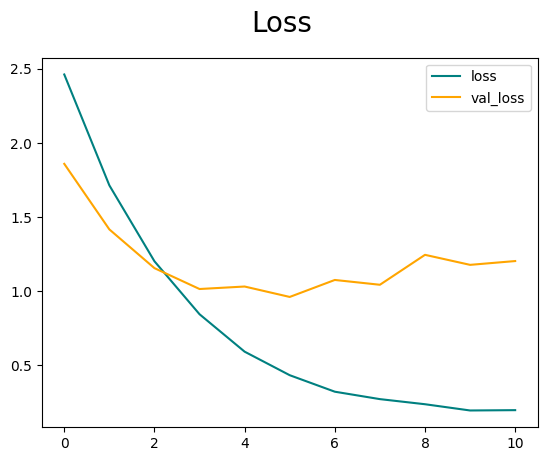

In [14]:
fig = plt.figure()
plt.plot(history.history['loss'] , color='teal' , label = 'loss')
plt.plot(history.history['val_loss'] , color='orange' , label = 'val_loss')
fig.suptitle('Loss' , fontsize = 20)
plt.legend(loc="upper right")
plt.show()

<b> Evaluate Perfomance </b>

In [15]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy 

In [18]:
accuracy_metric = Accuracy()
precision_metric=  Precision()
recall_metric = Recall()

for batch in testing_set.as_numpy_iterator():
    x , y = batch
    y_hat = model.predict(x)
    temp_y_hat = []
    for test_result in y_hat:
        results = test_result.tolist()
        temp_y_hat.append(results.index(max(results)))
    y_hat = temp_y_hat
    
    temp_y = []
    for real_result in y:
        results = real_result.tolist()
        temp_y.append(results.index(max(results)))
    y = temp_y 
    accuracy_metric.update_state(y , y_hat)
    precision_metric.update_state(y , y_hat)
    recall_metric.update_state(y , y_hat)


print(f"Precision - {precision_metric.result()} \nAccuracy - {accuracy_metric.result()} \nRecall - {recall_metric.result()}")

1/1 [==============================] - 1s 709ms/step
Precision - 0.9919999837875366 
Accuracy - 0.744087815284729 
Recall - 0.993766725063324


Save the model

In [17]:
models_path = './models/'
all_models = os.listdir(models_path)

# save the model with the last_index as it's identifier
model_path = os.path.join(models_path , f'model_{len(all_models)}.keras')
model.save(model_path)